# Medical-ML

## Introduction

This project aims to explore and analyze heart failure data to develop and evaluate machine learning models capable of delivering accurate predictions.

The dataset analyzed in this project focuses on heart failure, specifically determining whether a patient has heart disease based on various demographic characteristics and biomarkers. Originally titled *Heart Failure Prediction*, the dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?select=heart.csv).

**The introductory part contains setting up the environment, and function definitions.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from scipy.stats import spearmanr
from scipy.stats.contingency import association
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    TunedThresholdClassifierCV,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
np.random.seed(67868)
sns.set_theme(style='whitegrid')

In [3]:
# An improvement upon KNNImputer found in sklearn.
class BetterKNNImputer(KNNImputer):
    def __init__(
        self,
        numerical_cols: list,
        categorical_cols: list,
        target_col: str,
        is_target_numeric=True,
    ):
        self.numerical_cols = [col for col in numerical_cols if col != target_col]
        self.categorical_cols = [col for col in categorical_cols if col != target_col]
        self.target_col = target_col
        self.is_target_numeric = is_target_numeric
        
        self.numerical_transformer = StandardScaler()
        self.categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
        if is_target_numeric:
            self.target_transformer = StandardScaler()
            self.undersampler = None
        else:
            self.target_transformer = OneHotEncoder(handle_unknown='ignore')
            # NearMiss-1 seems to do well here.
            self.undersampler = NearMiss()
            
        super().__init__()
        self.weights = 'distance'

    def _preprocess_data_fit(
        self,
        X: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)
        
        # Standardize numerical columns.
        X[self.numerical_cols] = \
        self.numerical_transformer.fit_transform(X[self.numerical_cols])
        
        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = \
        self.categorical_transformer.fit_transform(X[self.categorical_cols])
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = \
        pd.DataFrame(data=categorical_dummies.toarray(),
                     columns=categorical_features)
        categorical_features = \
        [col for col in categorical_features if not col.endswith('nan')]
        categorical_dummies = categorical_dummies[categorical_features]
        
        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Perform undersampling if target variable is categorical.
        X_mask = ~X.isna().any(axis=1).to_numpy()
        old_target_mask = ~target.isna().any(axis=1).to_numpy()
        X_target_mask = X_mask & old_target_mask
        if not self.is_target_numeric:
            X_undersampled, target_undersampled = \
            self.undersampler.fit_resample(X[X_target_mask], target[X_target_mask])
            X = pd.concat([X[~X_target_mask], X_undersampled])
            target = pd.concat([target[~X_target_mask], target_undersampled])

        # Make sure index for X isn't nonsense.
        X = X.reset_index(drop=True)

        # Mask is useful for fitting.
        new_target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.fit_transform(target)
        
        return X, target, old_target_mask, new_target_mask

    def _preprocess_data_transform(
        self,
        X: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)

        # Standardize numerical columns.
        X[self.numerical_cols] = \
        self.numerical_transformer.transform(X[self.numerical_cols])

        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = \
        self.categorical_transformer.transform(X[self.categorical_cols])
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = \
        pd.DataFrame(data=categorical_dummies.toarray(),
                     columns=categorical_features)
        categorical_features = \
        [col for col in categorical_features if not col.endswith('nan')]
        categorical_dummies = categorical_dummies[categorical_features]

        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Mask is useful for transforming.
        target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.transform(target)
        
        return X, target, target_mask

    def fit(self, X: pd.DataFrame):
        new_data = X.copy()
        X, target, old_target_mask, new_target_mask = self._preprocess_data_fit(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = \
            pd.DataFrame(data=target.toarray(),
                         columns=target_features)
            target_features = \
            [col for col in target_features if not col.endswith('nan')]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~new_target_mask] = np.nan
            X = pd.concat([X, target], axis=1)

        # Set n_neighbors using a heuristic.
        self.n_neighbors = int(len(target) ** 0.5)
        
        return super().fit(X)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        new_data = X.copy()
        X, target, target_mask = self._preprocess_data_transform(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
            new_target = \
            super().transform(X)[:, [-1]]
            new_target = self.target_transformer.inverse_transform(new_target)[:, 0]
            new_data[self.target_col] = new_target
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = \
            pd.DataFrame(data=target.toarray(),
                         columns=target_features)
            target_features = \
            [col for col in target_features if not col.endswith('nan')]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~target_mask] = np.nan
            
            X = pd.concat([X, target], axis=1)
            new_target = \
            super().transform(X)[:, (-len(target_features)):]
            new_target = \
            self.target_transformer.categories_[0][np.argmax(new_target, axis=1)]
            new_data[self.target_col] = new_target
        
        return new_data

def cramerv(var1: np.ndarray, var2: np.ndarray) -> float:
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  return association(crosstab)

def diagnostic_odds_ratio(ground_truth: np.ndarray, predictions: np.ndarray) -> float:
    tn, fp, fn, tp = confusion_matrix(ground_truth, predictions).ravel()
    if fp == 0 and fn == 0:
        return tp * tn
    elif fp == 0 or fn == 0:
        return 0
    else:
        return (tp * tn) / (fp * fn)

diagnostic_odds_ratio_scorer = make_scorer(
    diagnostic_odds_ratio,
    greater_is_better=True,
)

## EDA

The **Exploratory Data Analysis** seeks to uncover the underlying structure of the data, verify its suitability for machine learning, and ensure there are no missing values, inbalances, or structural issues.

### Summary Statistics

**The head of data is presented below:**

In [4]:
data = pd.read_csv('heart_failure.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
3,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
4,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0


In [5]:
numeric_cols = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'Oldpeak',
]
categorical_cols = [
    'Sex',
    'ChestPainType',
    'FastingBS',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope',
]

**Verifying if there are missing values.**

In [6]:
display(pd.DataFrame(data.isna().sum(), columns = ['missing']))

,missing
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


**There aren't any missing values in the data.** 

It's useful to review summary statistics for numerical columns to identify any unusual or illogical values. Those values may not only be outliers, but, in extreme cases, could indicate errors in the dataset (e.g., an age of 167).

In [7]:
data[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,522.000000,522.000000,522.000000,522.000000,522.000000
mean,51.660920,131.197318,216.691571,143.622605,0.591762
std,9.497245,17.357076,88.244897,25.364167,0.899450
min,28.000000,80.000000,0.000000,63.000000,-1.500000
25%,44.000000,120.000000,195.000000,126.250000,0.000000
50%,52.000000,130.000000,226.000000,145.000000,0.000000
75%,58.000000,140.000000,264.000000,162.000000,1.000000
max,76.000000,200.000000,564.000000,202.000000,5.000000


Only *Age* and *MaxHR* seem to have reasonable values. Other variables seem to have a few potential outliers - thus, boxplots will be used to check for any isolated extremes.

### Distributions of numerical variables (boxplots)

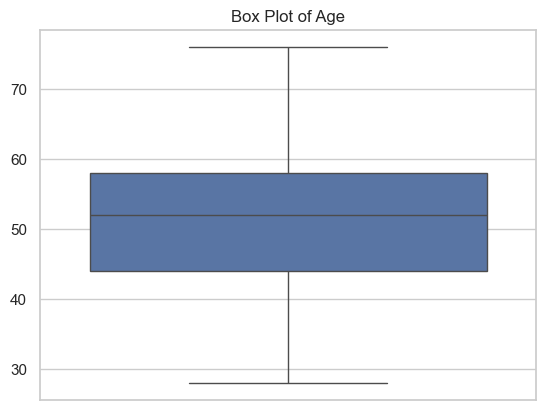

In [8]:
ax = sns.boxplot(data['Age'])
_ = ax.set(title='Box Plot of Age', ylabel=None)

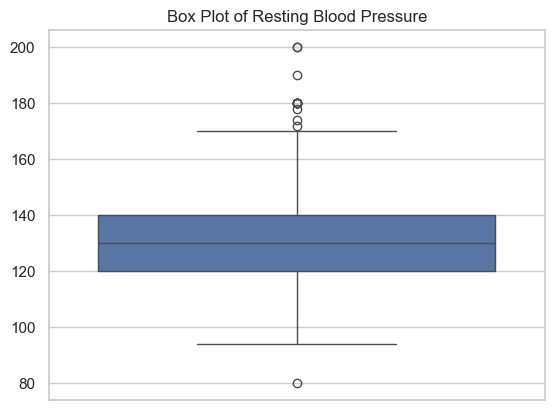

In [9]:
ax = sns.boxplot(data['RestingBP'])
_ = ax.set(title='Box Plot of Resting Blood Pressure', ylabel=None)

It seems there are a few extreme values for *Resting Blood Pressure*. **However, these are likely not a result of a measurement error, but a fat-tailed distribution, and should be kept in the dataset.**

A resting blood pressure of 80mmHg is low and could indicate hypotension, whereas 200mmHg  signals severe hypertension (it is extremely high but possible to attain).

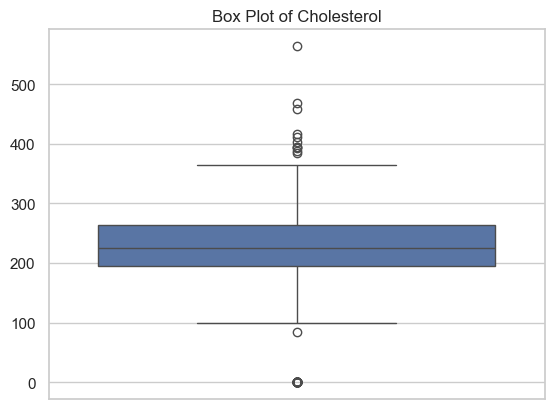

In [10]:
ax = sns.boxplot(data['Cholesterol'])
_ = ax.set(title='Box Plot of Cholesterol', ylabel=None)

**For *Cholesterol* a few observations should be removed or their value should be imputed.** In particular, a human cannot have 0 cholesterol, and the value above 500 warrants removal - such a case is extremely rare.

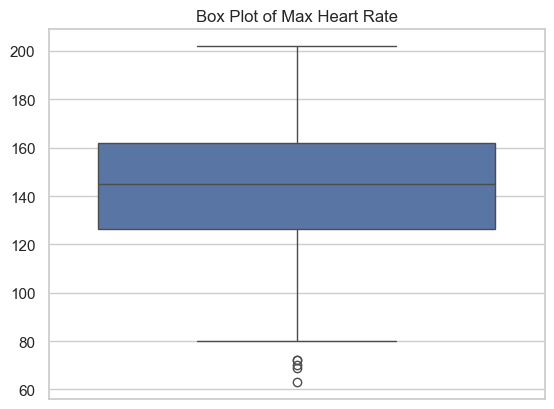

In [11]:
ax = sns.boxplot(data['MaxHR'])
_ = ax.set(title='Box Plot of Max Heart Rate', ylabel=None)

There are a few extreme values for *Max Heart Rate*. **However, these are likely not a result of a measurement error and should be kept in the dataset.**

A maximum heart rate below 80 is highly unusual, however it is possible and may indicate severe cardiovascular issues.

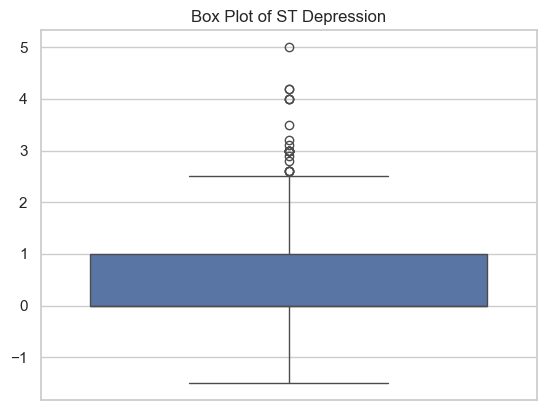

In [12]:
ax = sns.boxplot(data['Oldpeak'])
_ = ax.set(title='Box Plot of ST Depression', ylabel=None)

There are a few outliers for *ST Depression*, however, **they remain within realistic range** - a severe depression can oscillate around 5 mm and may indicate myocardial ischemia or other cardiac issues.

For *Cholesterol* observations above 500 will be removed, and observations with 0 will be replaced through *KNN Inputer*.

In [13]:
data = data[data['Cholesterol'] < 500]
data.loc[data['Cholesterol'] == 0, 'Cholesterol'] = np.nan

### Relationships between numerical variables

**Now collinearity will be checked.**

In [14]:
data[numeric_cols].corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.235697,0.132970,-0.391675,0.249109
RestingBP,0.235697,1.000000,0.125848,-0.109799,0.190216
Cholesterol,0.132970,0.125848,1.000000,-0.041538,0.112503
MaxHR,-0.391675,-0.109799,-0.041538,1.000000,-0.123762
Oldpeak,0.249109,0.190216,0.112503,-0.123762,1.000000


There doesn't seem to be a problem with collinearity, as all the values are within a proper range.

**Now the monotonic relationship between the numeric variables and the response variable will be checked via Spearman's $\rho$.**

In [15]:
numeric_predictive_power = pd.DataFrame(columns = ['rho'])
for col in numeric_cols:
    temp_data = data[~data[col].isna()]
    numeric_predictive_power.loc[col, :] = (
        [spearmanr(temp_data[col], temp_data['HeartDisease']).statistic]
    )
numeric_predictive_power

,rho
Age,0.238759
RestingBP,0.098001
Cholesterol,0.061974
MaxHR,-0.319722
Oldpeak,0.346148


**It seems that *RestingBP* and *Cholesterol* may not have that much of an effect on the risk of heart disease**, which is surprising, considering that cholesterol is commonly associated with it. However, a low correlation does not imply that the variables are not significant once models are built.

### Relationships between categorical variables

Now categorical variables will be assessed. First, it will be verfied if there are any extremely rare categories (< 1%).

In [16]:
for col in categorical_cols:
    display(pd.DataFrame(data[col].value_counts(normalize=True)))

,proportion
Sex,
M,0.710173
F,0.289827


,proportion
ChestPainType,
ASY,0.364683
ATA,0.299424
NAP,0.280230
TA,0.055662


,proportion
FastingBS,
0,0.84261
1,0.15739


,proportion
RestingECG,
Normal,0.641075
LVH,0.199616
ST,0.159309


,proportion
ExerciseAngina,
N,0.758157
Y,0.241843


,proportion
ST_Slope,
Up,0.646833
Flat,0.310940
Down,0.042226


The proportions fall within an acceptable range.

**The dependency between categorical variables and the response variable will be checked using *Cramer's V*.**

In [17]:
categorical_predictive_power = pd.DataFrame(columns = ['cramer_V'])
for col in categorical_cols:
    categorical_predictive_power.loc[col, :] = (
        [cramerv(data[col], data['HeartDisease'])]
    )
categorical_predictive_power

,cramer_V
Sex,0.241612
ChestPainType,0.442648
FastingBS,0.261378
RestingECG,0.056554
ExerciseAngina,0.479162
ST_Slope,0.517812


Most of these variables seem to have some predictive power, but a possible exception is *RestingECG*. 

**The class imbalance in the response variable should also be checked:**

In [18]:
print(
    'Proportion of people diagnosed with heart disease:',
    data['HeartDisease'].sum() / len(data)
)

Proportion of people diagnosed with heart disease: 0.21497120921305182


While the imbalance isn't extreme, it's worth considering during model training. 

## Machine Learning

### Data Preparation

In [19]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2)

In [20]:
imputer = BetterKNNImputer(
    numeric_cols,
    categorical_cols,
    'Cholesterol',
    is_target_numeric=True,
)
X_train['Cholesterol'] = imputer.fit_transform(X_train)['Cholesterol']
X_test['Cholesterol'] = imputer.transform(X_test)['Cholesterol']

In [21]:
X_train[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,416.000000,416.000000,416.000000,416.000000,416.000000
mean,51.372596,131.223558,239.266090,143.802885,0.595433
std,9.206761,16.768603,48.723465,25.634119,0.906896
min,28.000000,94.000000,100.000000,63.000000,-1.500000
25%,44.000000,120.000000,208.000000,126.000000,0.000000
50%,52.000000,130.000000,234.545373,146.000000,0.000000
75%,58.000000,140.000000,263.130973,162.000000,1.000000
max,74.000000,200.000000,458.000000,202.000000,5.000000


In [22]:
X_test[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,105.000000,105.000000,105.000000,105.000000,105.000000
mean,52.657143,131.247619,239.273046,142.752381,0.567619
std,10.488848,19.612977,55.855312,24.439793,0.872055
min,32.000000,80.000000,85.000000,80.000000,-1.100000
25%,44.000000,120.000000,204.000000,128.000000,0.000000
50%,54.000000,130.000000,234.000000,142.000000,0.000000
75%,61.000000,140.000000,271.000000,162.000000,1.000000
max,76.000000,200.000000,468.000000,186.000000,4.000000


In [23]:
for col in categorical_cols:
    display(pd.DataFrame(X_train[col].value_counts(normalize=True)))
    display(pd.DataFrame(X_test[col].value_counts(normalize=True)))

,proportion
Sex,
M,0.713942
F,0.286058


,proportion
Sex,
M,0.695238
F,0.304762


,proportion
ChestPainType,
ASY,0.377404
ATA,0.286058
NAP,0.283654
TA,0.052885


,proportion
ChestPainType,
ATA,0.352381
ASY,0.314286
NAP,0.266667
TA,0.066667


,proportion
FastingBS,
0,0.831731
1,0.168269


,proportion
FastingBS,
0,0.885714
1,0.114286


,proportion
RestingECG,
Normal,0.634615
LVH,0.209135
ST,0.156250


,proportion
RestingECG,
Normal,0.666667
ST,0.171429
LVH,0.161905


,proportion
ExerciseAngina,
N,0.757212
Y,0.242788


,proportion
ExerciseAngina,
N,0.761905
Y,0.238095


,proportion
ST_Slope,
Up,0.651442
Flat,0.307692
Down,0.040865


,proportion
ST_Slope,
Up,0.628571
Flat,0.323810
Down,0.047619


In [24]:
print('Train proportion:', y_train.sum() / len(y_train))
print('Test proportion:', y_test.sum() / len(y_test))

Train proportion: 0.22355769230769232
Test proportion: 0.18095238095238095


Split seems fairly good. It's time to try building the first few models. We're going to use **DOR** (**Diagnostic Odds Ratio**) for cross-validation. We will test a few potential models:
- logistic regression,
- random forest,
- decision tree boosting,
- SVM.

First we will simply use observation weighting, but afterwards we will also attempt to use undersampling/oversampling.

In [25]:
valid_thresholds = np.linspace(0.01, 0.5, 201)

### Weighting

In [26]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ]
)
logistic_pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('model', LogisticRegression(penalty=None, class_weight='balanced')),
    ]
)

threshold_tuning = TunedThresholdClassifierCV(
    logistic_pipeline,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
logistic_pipeline = threshold_tuning.estimator_
logistic_threshold = threshold_tuning.best_threshold_
display(logistic_pipeline)
print('Best threshold:', logistic_threshold)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty=None))])

Best threshold: 0.4216


In [27]:
transformer = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
forest_pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('model', RandomForestClassifier(class_weight='balanced')),
    ]
)

parameters = {
    'model__n_estimators': [5, 10, 15, 20],
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': [0.4, 0.6, 0.8],
    'model__max_depth': [2, 3, 5, 10, 15],
}
parameter_tuning = RandomizedSearchCV(
    forest_pipeline,
    parameters,
    n_iter=50,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
forest_pipeline = parameter_tuning.best_estimator_
display(forest_pipeline)

threshold_tuning = TunedThresholdClassifierCV(
    forest_pipeline,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
forest_threshold = threshold_tuning.best_threshold_
print('Best threshold:', forest_threshold)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        max_features=0.8, n_estimators=15))])

Best threshold: 0.4608


In [28]:
transformer = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)

boost_pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('model', AdaBoostClassifier(algorithm='SAMME')),
    ]
)

parameters = {
    'model__n_estimators': [5, 10, 15, 20],
    'model__learning_rate': [0.4, 0.8, 1.2, 1.6, 2],
    'model__estimator': [
        DecisionTreeClassifier(
            max_depth=1,
            criterion=crit,
            class_weight='balanced')
        for crit in ['gini', 'entropy']
    ],
}
parameter_tuning = GridSearchCV(
    boost_pipeline,
    parameters,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
boost_pipeline = parameter_tuning.best_estimator_
display(boost_pipeline)

threshold_tuning = TunedThresholdClassifierCV(
    boost_pipeline,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
boost_threshold = threshold_tuning.best_threshold_
print('Best threshold:', boost_threshold)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=1),
                                    learning_rate=0.4, n_estimators=5))])

Best threshold: 0.38484999999999997


In [29]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

svm_pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('model', SVC(class_weight='balanced')),
    ]
)

parameters = [
    {
        'model__kernel': ['linear'],
        'model__C': [2 ** (i - 9) for i in range(19)]
    },
    {
        'model__kernel': ['poly'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__degree': [i + 2 for i in range(4)],
        'model__coef0': [0, 0.1, 0.5, 1, 2, 10]
    },
    {
        'model__kernel': ['rbf'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__gamma': [2 ** (i - 8) for i in range(17)]
    },
]
parameter_tuning = RandomizedSearchCV(
    svm_pipeline,
    parameters,
    n_iter=50,
    scoring=diagnostic_odds_ratio_scorer,
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
svm_pipeline = parameter_tuning.best_estimator_
display(svm_pipeline)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 SVC(C=0.03125, class_weight='balanced', coef0=0.1, degree=2,
                     kernel='poly'))])

### Undersampling
We will use NearMiss undersampling. Each of the three variants will be tested during cross-validation.

In [30]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ]
)
logistic_pipeline_undersampled = Pipeline(
    [
        ('transformer', transformer),
        ('undersampler', NearMiss()),
        ('model', LogisticRegression(penalty=None)),
    ]
)

parameters = {'undersampler__version': [1, 2, 3]}
parameter_tuning = GridSearchCV(
    logistic_pipeline_undersampled,
    parameters,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
logistic_pipeline_undersampled = parameter_tuning.best_estimator_
display(logistic_pipeline_undersampled)

threshold_tuning = TunedThresholdClassifierCV(
    logistic_pipeline_undersampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
logistic_threshold_undersampled = threshold_tuning.best_threshold_
print('Best threshold:', logistic_threshold_undersampled)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('undersampler', NearMiss(version=3)),
                ('model', LogisticRegression(penalty=None))])

Best threshold: 0.4363


In [31]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)
forest_pipeline_undersampled = Pipeline(
    [
        ('transformer', transformer),
        ('undersampler', NearMiss()),
        ('model', RandomForestClassifier()),
    ]
)

parameters = {
    'undersampler__version': [1, 2, 3],
    'model__n_estimators': [5, 10, 15, 20],
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': [0.4, 0.6, 0.8],
    'model__max_depth': [2, 3, 5, 10, 15],
}
parameter_tuning = RandomizedSearchCV(
    forest_pipeline_undersampled,
    parameters,
    n_iter=50,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
forest_pipeline_undersampled = parameter_tuning.best_estimator_
display(forest_pipeline_undersampled)

threshold_tuning = TunedThresholdClassifierCV(
    forest_pipeline_undersampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
forest_threshold_undersampled = threshold_tuning.best_threshold_
print('Best threshold:', forest_threshold_undersampled)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('undersampler', NearMiss(version=3)),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=0.4, n_estimators=20))])

Best threshold: 0.4167


In [32]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

boost_pipeline_undersampled = Pipeline(
    [
        ('transformer', transformer),
        ('undersampler', NearMiss()),
        ('model', AdaBoostClassifier(algorithm='SAMME')),
    ]
)
parameters = {
    'undersampler__version': [1, 2, 3],
    'model__n_estimators': [5, 10, 15, 20],
    'model__learning_rate': [0.4, 0.8, 1.2, 1.6, 2],
    'model__estimator': [
        DecisionTreeClassifier(
            max_depth=1,
            criterion=crit)
        for crit in ['gini', 'entropy']
    ],
}
parameter_tuning = RandomizedSearchCV(
    boost_pipeline_undersampled,
    parameters,
    n_iter=50,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
boost_pipeline_undersampled = parameter_tuning.best_estimator_
display(boost_pipeline_undersampled)

threshold_tuning = TunedThresholdClassifierCV(
    boost_pipeline_undersampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
boost_threshold_undersampled = threshold_tuning.best_threshold_
print('Best threshold:', boost_threshold_undersampled)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('undersampler', NearMiss(version=3)),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(criterion='entropy',
                                                                     max_depth=1),
                                    learning_rate=0.8, n_estimators=15))])

Best threshold: 0.49755


In [33]:
transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

svm_pipeline_undersampled = Pipeline(
    [
        ('transformer', transformer),
        ('undersampler', NearMiss()),
        ('model', SVC()),
    ]
)

parameters = [
    {
        'undersampler__version': [1, 2, 3],
        'model__kernel': ['linear'],
        'model__C': [2 ** (i - 9) for i in range(19)]
    },
    {
        'undersampler__version': [1, 2, 3],
        'model__kernel': ['poly'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__degree': [i + 2 for i in range(4)],
        'model__coef0': [0, 0.1, 0.5, 1, 2, 10]
    },
    {
        'undersampler__version': [1, 2, 3],
        'model__kernel': ['rbf'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__gamma': [2 ** (i - 8) for i in range(17)]
    },
]
parameter_tuning = RandomizedSearchCV(
    svm_pipeline_undersampled,
    parameters,
    n_iter=50,
    scoring=diagnostic_odds_ratio_scorer,
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
svm_pipeline_undersampled = parameter_tuning.best_estimator_
display(svm_pipeline_undersampled)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('undersampler', NearMiss(version=3)),
                ('model', SVC(C=0.25, coef0=0.5, kernel='poly'))])

### Oversampling
We will use SMOTENC oversampling.

In [34]:
numeric_cols_count = len(numeric_cols)
total_cols_count = len(X_train.columns)
categorical_list = [i for i in range(numeric_cols_count, total_cols_count)]

In [35]:
transformer_numeric = ColumnTransformer(
    [('num', StandardScaler(), numeric_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
transformer_categorical = ColumnTransformer(
    [('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_list)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
logistic_pipeline_oversampled = Pipeline(
    [
        ('transformer_numeric', transformer_numeric),
        ('oversampler', SMOTENC(categorical_list)),
        ('transformer_categorical', transformer_categorical),
        ('model', LogisticRegression(penalty=None)),
    ]
)

threshold_tuning = TunedThresholdClassifierCV(
    logistic_pipeline_oversampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
logistic_pipeline_oversampled = threshold_tuning.estimator_
logistic_threshold_oversampled = threshold_tuning.best_threshold_
display(logistic_pipeline_oversampled)
print('Best threshold:', logistic_threshold_oversampled)

Pipeline(steps=[('transformer_numeric',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('oversampler',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10])),
                ('transformer_categorical',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10])])),
                ('model', LogisticRegression(penalty=None))])

Best threshold: 0.3138


In [36]:
transformer_numeric = ColumnTransformer(
    [('num', StandardScaler(), numeric_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
transformer_categorical = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_list)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
forest_pipeline_oversampled = Pipeline(
    [
        ('transformer_numeric', transformer_numeric),
        ('oversampler', SMOTENC(categorical_list)),
        ('transformer_categorical', transformer_categorical),
        ('model', RandomForestClassifier()),
    ]
)

parameters = {
    'model__n_estimators': [5, 10, 15, 20],
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': [0.4, 0.6, 0.8],
    'model__max_depth': [2, 3, 5, 10, 15],
}
parameter_tuning = RandomizedSearchCV(
    forest_pipeline_oversampled,
    parameters,
    n_iter=50,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
forest_pipeline_oversampled = parameter_tuning.best_estimator_
display(forest_pipeline_oversampled)

threshold_tuning = TunedThresholdClassifierCV(
    forest_pipeline_oversampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
forest_threshold_oversampled = threshold_tuning.best_threshold_
print('Best threshold:', forest_threshold_oversampled)

Pipeline(steps=[('transformer_numeric',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('oversampler',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10])),
                ('transformer_categorical',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10])])),
                ('model',
                 RandomForestClassifier(max_depth=3, max_features=0.4,
                                        n_estimators=15))])

Best threshold: 0.4755


In [37]:
transformer_numeric = ColumnTransformer(
    [('num', StandardScaler(), numeric_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
transformer_categorical = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_list)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)

boost_pipeline_oversampled = Pipeline(
    [
        ('transformer_numeric', transformer_numeric),
        ('oversampler', SMOTENC(categorical_list)),
        ('transformer_categorical', transformer_categorical),
        ('model', AdaBoostClassifier(algorithm='SAMME')),
    ]
)

parameters = {
    'model__n_estimators': [5, 10, 15, 20],
    'model__learning_rate': [0.4, 0.8, 1.2, 1.6, 2],
    'model__estimator': [
        DecisionTreeClassifier(
            max_depth=1,
            criterion=crit)
        for crit in ['gini', 'entropy']
    ],
}
parameter_tuning = GridSearchCV(
    boost_pipeline_oversampled,
    parameters,
    scoring='average_precision',
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
boost_pipeline_oversampled = parameter_tuning.best_estimator_
display(boost_pipeline_oversampled)

threshold_tuning = TunedThresholdClassifierCV(
    boost_pipeline_oversampled,
    scoring=diagnostic_odds_ratio_scorer,
    thresholds=valid_thresholds,
    cv=10,
)
threshold_tuning.fit(X_train, y_train)
boost_threshold_oversampled = threshold_tuning.best_threshold_
print('Best threshold:', boost_threshold_oversampled)

Pipeline(steps=[('transformer_numeric',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('oversampler',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10])),
                ('transformer_categorical',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10])])),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.8, n_estimators=20))])

Best threshold: 0.5


In [38]:
transformer_numeric = ColumnTransformer(
    [('num', StandardScaler(), numeric_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)
transformer_categorical = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_list)],
    remainder='passthrough',
    force_int_remainder_cols=False,
)

svm_pipeline_oversampled = Pipeline(
    [
        ('transformer_numeric', transformer_numeric),
        ('oversampler', SMOTENC(categorical_list)),
        ('transformer_categorical', transformer_categorical),
        ('model', SVC()),
    ]
)

parameters = [
    {
        'model__kernel': ['linear'],
        'model__C': [2 ** (i - 9) for i in range(19)]
    },
    {
        'model__kernel': ['poly'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__degree': [i + 2 for i in range(4)],
        'model__coef0': [0, 0.1, 0.5, 1, 2, 10]
    },
    {
        'model__kernel': ['rbf'],
        'model__C': [2 ** (i - 9) for i in range(10)],
        'model__gamma': [2 ** (i - 8) for i in range(17)]
    },
]
parameter_tuning = RandomizedSearchCV(
    svm_pipeline_oversampled,
    parameters,
    n_iter=50,
    scoring=diagnostic_odds_ratio_scorer,
    cv=10,
)
parameter_tuning.fit(X_train, y_train)
svm_pipeline_oversampled = parameter_tuning.best_estimator_
display(svm_pipeline_oversampled)

Pipeline(steps=[('transformer_numeric',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('oversampler',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10])),
                ('transformer_categorical',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10])])),
                ('model', SVC(C=0.00390625, gamma=0.125))])

### Summary

In [39]:
summary_data = pd.DataFrame(columns=['weighted', 'undersampled', 'oversampled'])
summary_data.loc['logistic_regression', 'weighted'] = diagnostic_odds_ratio(
    y_test,
    logistic_pipeline.predict_proba(X_test)[:, 1]
    >= logistic_threshold,
)
summary_data.loc['logistic_regression', 'undersampled'] = diagnostic_odds_ratio(
    y_test,
    logistic_pipeline_undersampled.predict_proba(X_test)[:, 1]
    >= logistic_threshold_undersampled, 
)
summary_data.loc['logistic_regression', 'oversampled'] = diagnostic_odds_ratio(
    y_test,
    logistic_pipeline_oversampled.predict_proba(X_test)[:, 1]
    >= logistic_threshold_oversampled, 
)
summary_data.loc['random_forest', 'weighted'] = diagnostic_odds_ratio(
    y_test,
    forest_pipeline.predict_proba(X_test)[:, 1]
    >= forest_threshold, 
)
summary_data.loc['random_forest', 'undersampled'] = diagnostic_odds_ratio(
    y_test,
    forest_pipeline_undersampled.predict_proba(X_test)[:, 1]
    >= forest_threshold_undersampled, 
)
summary_data.loc['random_forest', 'oversampled'] = diagnostic_odds_ratio(
    y_test,
    forest_pipeline_oversampled.predict_proba(X_test)[:, 1]
    >= forest_threshold_oversampled, 
)
summary_data.loc['boosting', 'weighted'] = diagnostic_odds_ratio(
    y_test,
    boost_pipeline.predict_proba(X_test)[:, 1]
    >= boost_threshold, 
)
summary_data.loc['boosting', 'undersampled'] = diagnostic_odds_ratio(
    y_test,
    boost_pipeline_undersampled.predict_proba(X_test)[:, 1]
    >= boost_threshold_undersampled,
)
summary_data.loc['boosting', 'oversampled'] = diagnostic_odds_ratio(
    y_test,
    boost_pipeline_oversampled.predict_proba(X_test)[:, 1]
    >= boost_threshold_oversampled,
)
summary_data.loc['svm', 'weighted'] = diagnostic_odds_ratio(
    y_test,
    svm_pipeline.predict(X_test)
)
summary_data.loc['svm', 'undersampled'] = diagnostic_odds_ratio(
    y_test,
    svm_pipeline_undersampled.predict(X_test)
)
summary_data.loc['svm', 'oversampled'] = diagnostic_odds_ratio(
    y_test,
    svm_pipeline_oversampled.predict(X_test)
)
summary_data

,weighted,undersampled,oversampled
logistic_regression,29.973684,40.233333,32.111111
random_forest,23.282609,23.333333,32.083333
boosting,43.714286,42.321429,15.723077
svm,47.730769,28.5,40.233333


In [40]:
summary_data = pd.DataFrame(columns=['weighted', 'undersampled', 'oversampled'])
summary_data.loc['logistic_regression', 'weighted'] = diagnostic_odds_ratio(
    y_train,
    logistic_pipeline.predict_proba(X_train)[:, 1]
    >= logistic_threshold,
)
summary_data.loc['logistic_regression', 'undersampled'] = diagnostic_odds_ratio(
    y_train,
    logistic_pipeline_undersampled.predict_proba(X_train)[:, 1]
    >= logistic_threshold_undersampled,
)
summary_data.loc['logistic_regression', 'oversampled'] = diagnostic_odds_ratio(
    y_train,
    logistic_pipeline_oversampled.predict_proba(X_train)[:, 1]
    >= logistic_threshold_oversampled,
)
summary_data.loc['random_forest', 'weighted'] = diagnostic_odds_ratio(
    y_train,
    forest_pipeline.predict_proba(X_train)[:, 1]
    >= forest_threshold,
)
summary_data.loc['random_forest', 'undersampled'] = diagnostic_odds_ratio(
    y_train,
    forest_pipeline_undersampled.predict_proba(X_train)[:, 1]
    >= forest_threshold_undersampled,
)
summary_data.loc['random_forest', 'oversampled'] = diagnostic_odds_ratio(
    y_train,
    forest_pipeline_oversampled.predict_proba(X_train)[:, 1]
    >= forest_threshold_oversampled,
)
summary_data.loc['boosting', 'weighted'] = diagnostic_odds_ratio(
    y_train,
    boost_pipeline.predict_proba(X_train)[:, 1]
    >= boost_threshold,
)
summary_data.loc['boosting', 'undersampled'] = diagnostic_odds_ratio(
    y_train,
    boost_pipeline_undersampled.predict_proba(X_train)[:, 1]
    >= boost_threshold_undersampled,
)
summary_data.loc['boosting', 'oversampled'] = diagnostic_odds_ratio(
    y_train,
    boost_pipeline_oversampled.predict_proba(X_train)[:, 1]
    >= boost_threshold_oversampled,
)
summary_data.loc['svm', 'weighted'] = diagnostic_odds_ratio(
    y_train,
    svm_pipeline.predict(X_train)
)
summary_data.loc['svm', 'undersampled'] = diagnostic_odds_ratio(
    y_train,
    svm_pipeline_undersampled.predict(X_train)
)
summary_data.loc['svm', 'oversampled'] = diagnostic_odds_ratio(
    y_train,
    svm_pipeline_oversampled.predict(X_train)
)
summary_data

,weighted,undersampled,oversampled
logistic_regression,33.589062,31.25,29.340659
random_forest,89.660377,202.335938,64.291317
boosting,25.104878,22.645688,29.098611
svm,27.876984,75.673469,27.131783
